# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services - Part 2

In this project, I will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. I'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, I'll apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that I will use has been provided by partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

I am familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. We are also free to choose whatever approach we'd like to analyzing the data rather than follow pre-determined steps. In work on this project, make sure that we carefully document steps and decisions, since our main deliverable for this project will be a blog post reporting our findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score,recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, learning_curve
import xgboost as xgb
from xgboost import plot_importance
import time
from utils import *
%matplotlib inline

C:\Users\wangx\.conda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).



In [3]:
# Functions from previous work
def df_clean(df):
    """
    This function is to clean the raw data,apply ETL pipeline to convert data for analysis

    INPUT
    df - dataframe

    OUTPUT
    df - dataframe cleaned

    """
    # # Clean customers data and plot missing values
    clear_X_XX(df)
    convert_EINGEFUEGT_AM(df)
    convert_OST_WEST_KZ(df)
    unknown_to_nan_replace(df)
    convert_TITEL_KZ(df)
    df = split_CAMEO_INTL_2015(df)
    drop_columns_per_list(df,fld_drop_list)
    df = df_to_float(df)
    outlier_to_nan(df,columns_with_outlier)
    df = one_hot_encoding(df,onehot_list)
    df_fillna(df)
    df_cleaned = feature_scaling(df)
    return df_cleaned

## Part 1: Customer Segmentation Report

The main bulk of this analysis will come in this part of the project. Here, I will use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, I will describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1. Dimension reduction - PCA

Principal Component Analysis is a mathematical technique used for dimensionality reduction. Its goal is to reduce the number of features whilst keeping most of the original information. - https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51

#### 1.1 Clean data set

In [418]:
# Load Udacity_AZDIAS_052018.csv
azdias = df_load_azdias()

C:\Users\wangx\.conda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [419]:
# Load Udacity_CUSTOMERS_052018.csv
customers = df_load_customers()

In [420]:
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [421]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4


In [422]:
azdias.set_index('LNR',inplace=True)

In [423]:
customers.set_index('LNR',inplace=True)

In [424]:
# Sample data for modeling
df = azdias.sample(100000)

In [425]:
df = df_clean(df)

In [426]:
# Use functions prepared to clean data
azdias_cleaned = df_clean(azdias)

In [427]:
customers_cleaned = df_clean(customers)

In [428]:
customers_cleaned

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
0,-0.325074,-0.564912,-0.322324,-0.421812,0.0,0.0,-0.150360,-0.405560,-0.116283,-2.144783,...,-0.431254,-0.496938,-0.374916,1.659933,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409
1,4.271391,-0.305670,-0.322324,-0.421812,0.0,0.0,0.723246,-0.405560,-0.116283,0.147901,...,-0.431254,-0.496938,-0.374916,1.659933,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409
2,-0.325074,-1.601882,-0.322324,-0.421812,0.0,0.0,-1.023965,-0.405560,-0.116283,0.147901,...,-0.431254,2.012325,-0.374916,-0.602434,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409
3,-0.325074,-1.083397,-1.173610,-1.099424,0.0,0.0,-1.897571,-0.405560,-0.116283,-2.144783,...,2.318819,-0.496938,-0.374916,-0.602434,1.589481,-0.19324,-1.144506,-0.28938,-0.074823,-0.177409
4,-0.325074,2.027511,1.380249,3.643858,0.0,0.0,1.596852,-0.405560,-0.116283,0.147901,...,-0.431254,2.012325,-0.374916,-0.602434,1.589481,-0.19324,-1.144506,-0.28938,-0.074823,-0.177409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,-0.325074,-0.824155,-0.747967,-0.421812,0.0,0.0,-1.023965,-0.405560,-0.116283,0.147901,...,-0.431254,2.012325,-0.374916,-0.602434,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409
191648,0.249484,-0.564912,-0.322324,-1.099424,0.0,0.0,-1.897571,-0.405560,-0.116283,-2.144783,...,-0.431254,-0.496938,-0.374916,1.659933,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409
191649,-0.325074,0.731299,-0.322324,-0.421812,0.0,0.0,0.723246,-0.405560,-0.116283,0.147901,...,2.318819,-0.496938,-0.374916,-0.602434,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409
191650,-0.325074,0.212815,0.954606,1.611023,0.0,0.0,1.596852,1.517432,-0.116283,0.147901,...,-0.431254,-0.496938,2.667267,-0.602434,-0.629136,-0.19324,0.873739,-0.28938,-0.074823,-0.177409


#### 1.2 Principal Component Analysis employed to reduce the input attributes for Kmeans clustering

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.- https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

In [429]:
# Plot the diagram for variance explained with maximized number of components
pca_all = PCA(n_components=353)
pca_all.fit(df)

PCA(copy=True, iterated_power='auto', n_components=353, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

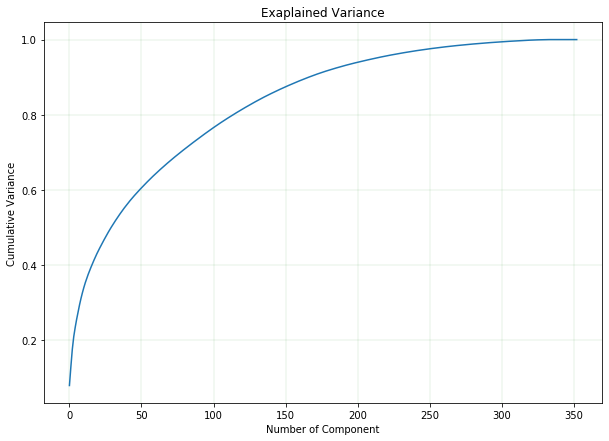

In [433]:
plt.figure(figsize=(10,7))
plt.plot(pca_all.explained_variance_ratio_.cumsum(),)

plt.title("Exaplained Variance")
plt.xlabel("Number of Component")
plt.ylabel("Cumulative Variance")
plt.grid(linewidth=0.1,color="g")
plt.show()

In [434]:
sum(pca.explained_variance_ratio_[:120])

0.8119976848947518

#### 1.3 Use mailout train data to build the customer predict model and find the important attributes

XGBoost algorithm: has become the ultimate weapon of many data scientist. It’s a highly sophisticated algorithm, powerful enough to deal with all sorts of irregularities of data.- https://medium.com/@imoisharma18/gentle-introduction-of-xgboost-library-2b1ac2669680

In [437]:
def mailout_train_data_processing():
    """
    This function is to clean mailout_train data,apply ETL pipeline, and return data sets for model training

    INPUT

    OUTPUT
    X_train - dataframe for model training
    y_train - label for response
    """
    mailout_train = df_load_mailout_train()
    train_LNR = mailout_train['LNR']
    train_y = mailout_train['RESPONSE']
    mailout_train.drop(columns=['RESPONSE','LNR'],inplace=True)
    train_x = df_clean(mailout_train)
    return train_x,train_y

In [438]:
train_x,train_y = mailout_train_data_processing()

C:\Users\wangx\.conda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [439]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, stratify=train_y, test_size=0.3, random_state=46)

##### Metric selection: roc_auc_score in this model

Reciever Operating Characteristic or ROC curve is often utilised as a visualisation plot to measure the performance of a binary classifier. It’s not a metric of the model, per se, rather the graphical representation of the True Positive Rate (TPR) versus False Positive rate (FPR) at various classification threshold from 0 to 1. It can also be thought of as the power of Type I Error (False Positives) decision rule function.

This ROC visualization plot should aid at understanding the trade-off between the rates. We can also qunatify area under the curve also know as AUC using scikit-learn’s roc_auc_score metric, in order to assess the performance of the model. The closer the score to 1 the better the model distinguishes the clasess - https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663

Although there is a simple way of finding optimal hyperparameters is by testing every combination of hyperparameters which is called Grid Search. - https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a, however, I found the testing AUC score is not linearly dependent on the best score with the train data set,so I decided to print the score for combination of hyperparameters and check if there are balance between AUC scores of train and test

In [178]:
def model_tuning(X_train,X_test,y_train,y_test):
    """
    This function is to find the parameters for model with best AUC score

    INPUT
    model - classification mode to be trained and tested
    param_list - Grid Search parameters
    X_train - data frame to be trained
    y_train
 
    OUTPUT
    X_train - dataframe for model training
    y_train - label for response
    """
    score = pd.DataFrame(columns=['max_depth','min_child_weight','n_estimators','learning_rate','Train_AUC','Test_AUC'])
                    
    for max_depth in [5,7,9]:
        for min_child_weight in [1,2]:
            for n_estimators in [200,240,300]:
                for learning_rate in [0.01,0.015,0.02,0.1]:  
                    model = xgb.XGBClassifier(booster='gbtree', 
                                          colsample_bylevel=1,
                                          colsample_bynode=1, 
                                          colsample_bytree=0.7,
                                          eval_metric='auc',
                                          gamma=1.0, 
                                          gpu_id=-1, 
                                          importance_type='gain',
                                          use_label_encoder=False,
                                          max_delta_step=0, 
                                          missing=None,
                                          n_jobs=-1,
                                          nthread=None, 
                                          random_state=64,
                                          reg_alpha=1e-09, 
                                          reg_lambda=1, 
                                          scale_pos_weight=1, 
                                          seed=None,
                                          subsample=0.5,
                                          max_depth=max_depth,
                                          min_child_weight=min_child_weight,
                                          n_estimators=n_estimators,
                                          learning_rate=learning_rate,
                                             )
        
                    model.fit(X_train,y_train)

                    auc_train = roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
                    auc_test = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

                    auc = {'max_depth':max_depth,'min_child_weight':min_child_weight,'n_estimators':n_estimators,'learning_rate':learning_rate,'Train_AUC':auc_train,'Test_AUC':auc_test}
                    score = score.append(auc, ignore_index=True)
                    
    return score


In [179]:
score = model_tuning(X_train,X_test,y_train,y_test)
score

,max_depth,min_child_weight,n_estimators,learning_rate,Train_AUC,Test_AUC
0,5.0,1.0,200.0,0.010,0.851734,0.769466
1,5.0,1.0,200.0,0.015,0.876444,0.764899
2,5.0,1.0,200.0,0.020,0.896797,0.766689
3,5.0,1.0,200.0,0.100,0.977447,0.683961
4,5.0,1.0,240.0,0.010,0.860890,0.771352
...,...,...,...,...,...,...
67,9.0,2.0,240.0,0.100,0.986960,0.669659
68,9.0,2.0,300.0,0.010,0.911722,0.764014
69,9.0,2.0,300.0,0.015,0.931547,0.763662
70,9.0,2.0,300.0,0.020,0.951607,0.746680


In [182]:
pd.set_option('display.max_rows', 80)
score.head(72)

,max_depth,min_child_weight,n_estimators,learning_rate,Train_AUC,Test_AUC
0,5.0,1.0,200.0,0.010,0.851734,0.769466
1,5.0,1.0,200.0,0.015,0.876444,0.764899
2,5.0,1.0,200.0,0.020,0.896797,0.766689
3,5.0,1.0,200.0,0.100,0.977447,0.683961
4,5.0,1.0,240.0,0.010,0.860890,0.771352
5,5.0,1.0,240.0,0.015,0.888946,0.767350
6,5.0,1.0,240.0,0.020,0.908641,0.767377
7,5.0,1.0,240.0,0.100,0.980790,0.674569
8,5.0,1.0,300.0,0.010,0.880626,0.768593
9,5.0,1.0,300.0,0.015,0.906400,0.765203


In [440]:
# Choosed best fit model parameters,with balanced score between train and test
# max_depth	min_child_weight	n_estimators	learning_rate	Train_AUC	Test_AUC
# 9.0	    2.0	                200.0	        0.015	        0.908560	0.770909
model = xgb.XGBClassifier(booster='gbtree',
                          colsample_bylevel=1,
                          colsample_bynode=1,
                          colsample_bytree=0.7,
                          eval_metric='auc',
                          gamma=1.0,
                          gpu_id=-1,
                          importance_type='gain',
                          use_label_encoder=False,
                          max_delta_step=0,
                          missing=None,
                          n_jobs=-1,
                          nthread=None,
                          random_state=64,
                          reg_alpha=1e-09,
                          reg_lambda=1,
                          scale_pos_weight=1,
                          seed=None,
                          subsample=0.5,
                          max_depth=9,
                          min_child_weight=2,
                          n_estimators=200,
                          learning_rate=0.015,
                          )

In [441]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.015, max_delta_step=0,
              max_depth=9, min_child_weight=2, missing=None,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              nthread=24, num_parallel_tree=1, objective='binary:logistic',
              random_state=64, reg_alpha=1e-09, reg_lambda=1,
              scale_pos_weight=1, seed=64, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [442]:
# AUC score for model employed
auc_train = roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
auc_test = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

In [443]:
auc_train,auc_test

(0.9085597476353029, 0.7709091935737293)

In [444]:
# Feature importance of each attributes, sorted by value
df_feature_importance = pd.DataFrame({'Field': X_train.columns, 'Feature_importance': model.feature_importances_})
df_feature_importance = df_feature_importance.sort_values(by=['Feature_importance'],ascending = False)

In [445]:
df_feature_importance['Sum_importance'] = np.cumsum(df_feature_importance['Feature_importance'])
df_feature_importance

,Field,Feature_importance,Sum_importance
339,LP_STATUS_GROB_5.0,0.006616,0.006616
117,KBA13_ANTG2,0.006533,0.013149
246,PLZ8_HHZ,0.005730,0.018879
23,D19_SOZIALES,0.005527,0.024405
318,LP_FAMILIE_FEIN_10.0,0.005509,0.029914
...,...,...,...
270,TITEL_KZ,0.000000,1.000000
305,FINANZTYP_3.0,0.000000,1.000000
306,FINANZTYP_4.0,0.000000,1.000000
332,LP_STATUS_FEIN_8.0,0.000000,1.000000


In [446]:
df_feature_importance.head(20)

,Field,Feature_importance,Sum_importance
339,LP_STATUS_GROB_5.0,0.006616,0.006616
117,KBA13_ANTG2,0.006533,0.013149
246,PLZ8_HHZ,0.005730,0.018879
23,D19_SOZIALES,0.005527,0.024405
318,LP_FAMILIE_FEIN_10.0,0.005509,0.029914
35,FINANZ_SPARER,0.005392,0.035306
309,LP_FAMILIE_FEIN_1.0,0.005322,0.040628
298,CJT_GESAMTTYP_2.0,0.005094,0.045723
133,KBA13_CCM_1200,0.004931,0.050653
202,KBA13_RENAULT,0.004881,0.055534


In [447]:
# Less important features listed after summarized by 50% 
df_feature_remove = df_feature_importance[df_feature_importance['Sum_importance'] > 0.50]

In [448]:
# Columns to be dropped before Kmeans clustering
drop_list_less_important = df_feature_remove['Field'].to_list()

In [449]:
drop_list_less_important

['KBA13_HALTER_25',
 'SEMIO_SOZ',
 'D19_LOTTO',
 'D19_KONSUMTYP_MAX',
 'PLZ8_ANTG3',
 'KBA05_DIESEL',
 'KBA13_CCM_3001',
 'KBA05_MAXHERST',
 'KBA13_HHZ',
 'KBA13_KRSSEG_VAN',
 'GEBURTSJAHR',
 'KBA13_KMH_140',
 'KBA13_VORB_2',
 'FINANZ_HAUSBAUER',
 'KBA13_MERCEDES',
 'KBA05_KW1',
 'KBA13_BMW',
 'KBA13_SITZE_4',
 'RETOURTYP_BK_S',
 'KBA13_KW_121',
 'KBA13_HALTER_20',
 'KBA13_AUTOQUOTE',
 'RT_UEBERGROESSE',
 'KBA13_VORB_1_2',
 'KONSUMNAEHE',
 'KBA05_MOD3',
 'PRAEGENDE_JUGENDJAHRE',
 'D19_KONSUMTYP',
 'KBA13_CCM_1500',
 'SEMIO_KULT',
 'KBA05_VORB0',
 'SEMIO_PFLICHT',
 'KBA13_SITZE_6',
 'KBA13_KW_60',
 'KBA13_SEG_SPORTWAGEN',
 'KBA13_HALTER_65',
 'KBA13_ANZAHL_PKW',
 'ALTERSKATEGORIE_FEIN',
 'KBA13_CCM_1600',
 'CAMEO_DEUG_2015_6.0',
 'KBA13_SEG_OBERKLASSE',
 'KBA13_BJ_2004',
 'KBA13_AUDI',
 'KBA13_CCM_2501',
 'KBA13_CCM_3000',
 'FINANZ_MINIMALIST',
 'KBA05_GBZ',
 'GEMEINDETYP',
 'KBA13_KW_120',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'LP_STATUS_GROB_2.0',
 'HEALTH_TYP',
 'D19_BANKEN_ONLINE_QUOTE_12

In [451]:
# Features to be kept
df_feature = df_feature_importance[df_feature_importance['Sum_importance'] <= 0.5].sort_values(by=['Feature_importance'],ascending = False)


In [452]:
df_feature.shape

(128, 3)

In [453]:
def feature_importances_plot(model, features, n_feature):
    """
    This function is to plot feature importance by order

    INPUT
    model - classification mode employed
    features - attributes 
    feature_nb - number of features to be plotted

    OUTPUT

    """
    # Get feature importance from the model employed
    feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values('Importance', ascending = False).reset_index(drop = True)
 
    # Plot the importance
    plt.figure(figsize=(9, 10))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(feature_importances.index[:n_feature]))), 
                feature_importances['Importance'][:n_feature], 
                align = 'center', edgecolor = 'k')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:n_feature]))))
    ax.set_yticklabels(feature_importances['Feature'][:n_feature], size = 12)
    plt.title(f'Feature Importances', size = 15) 

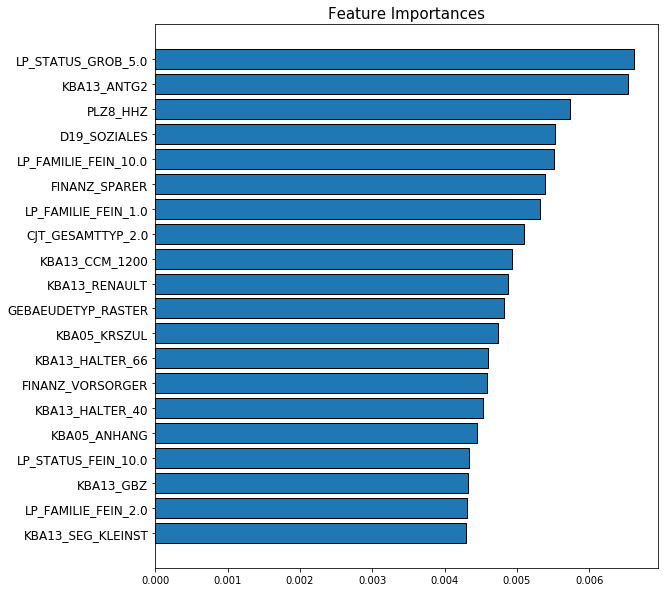

In [454]:
feature_importances_plot(model=model, features=X_train.columns,n_feature=20)

##### Top important attributes of customer:
LP_STATUS_GROB_5.0 - social status: people who are the top earners  
KBA13_ANTG2 - people who live in the PLZ8 area with higher share number of 3-5 family houses   
PLZ8_HHZ - people live in the area where there are larger number of households within the PLZ8  
D19_SOZIALES - people have higher transactional activity on the product group of social  
LP_FAMILIE_FEIN_10.0 - family type of two-generational household  
FINANZ_SPARER - financial typology: lower possibility of money saver   
LP_FAMILIE_FEIN_1.0 - family type of single person   
CJT_GESAMTTYP_2.0 - customer journey typology: Advertising and Consumption traditionalist  


In [455]:
feature_remove_list = df_feature_remove

#### 1.5 Perform Dimensionality Reduction

In [456]:
# Reduce data columns for kmeans clustering
azdias_kmodel = azdias_cleaned.drop(columns = df_feature_remove.Field)
customers_kmodel = customers_cleaned.drop(columns = df_feature_remove.Field)

In [457]:
azdias_kmodel.shape

(891221, 128)

In [251]:
# Number of components selected and its variance explained, I choose 55 compontes to keep more than 80% of the variance
for k in range(50,55):
    pca_k = PCA(n_components = k)
    df_k = pca_k.fit_transform(azdias_kmodel)
    print("Number of components %d and variance explained %f" % (k, sum(pca_k.explained_variance_ratio_)))

Number of components 50 and variance explained 0.778489
Number of components 51 and variance explained 0.783862
Number of components 52 and variance explained 0.790216
Number of components 53 and variance explained 0.795636
Number of components 54 and variance explained 0.801373


In [253]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_55 = PCA(n_components=55)
azdias_pca = pca_55.fit_transform(azdias_kmodel)
azdias_pca.shape

(891221, 55)

In [256]:
pca_55_customers = PCA(n_components=55)
customers_pca = pca_55_customers.fit_transform(customers_kmodel)
customers_pca.shape

(191652, 55)

In [258]:
def elbow_method_plot(df):
    """
    This function is to plot the SSE scores for kmeans model by number of clusters

    INPUT
    df - data frame to be classified

    OUTPUT

    """
    scores = []
    K = range(1, 20)

    for k in K:
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(df)

        # SSE score for kmeans model 
        score = np.abs(model.score(df))
        # scores.append(fit_kmeans(data, center))
        scores.append(score)

    # Plot the scores against the clusters
    plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(K, scores, linestyle='--', marker='o')
    plt.ylabel('Score')
    plt.xlabel('Number of clusters')


Wall time: 2h 7min 56s


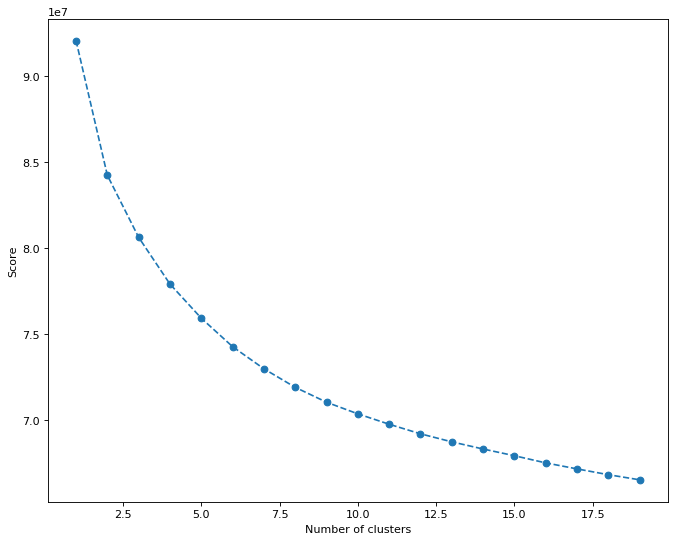

In [259]:
%%time
elbow_method_plot(azdias_pca)

In [329]:
def plot_cluster_distribution_compare(n_clusters,azdias, customers):
    """
    This function is to plot percentage of peoples belong to which cluster,by input the number of clusters to be classified, 
    and compare the distribution between general population and customer

    INPUT
    n_clusters - number of clusters to be clustered
    azdias - data frame for general population to be clustered
    customers - data frame for customers to be clustered

    OUTPUT

    """
    # Return kmodel with number of clusters to be classified
    kModel = KMeans(n_clusters=n_clusters,random_state=26)
    # Fit the model with data 
    kModel.fit(azdias)

    # Predict the cluster of the data
    azdias_labels = kModel.predict(azdias)
    customers_labels = kModel.predict(customers)

    # Return label of clusters and count of each cluster
    labels, azdias_labels_counts = np.unique(azdias_labels, return_counts=True)
    _, customers_labels_counts = np.unique(customers_labels, return_counts=True)

    # Return percentage of people in each cluster
    azdias_labels_pct = azdias_labels_counts * 100 / len(azdias_labels)
    customers_labels_pct = customers_labels_counts * 100 / len(customers_labels)
    
    # Plot the percentage of people in each cluster for General Population and Customers
    labels = labels + 1
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, azdias_labels_pct, width, label='General Population')
    rects2 = ax.bar(x + width / 2, customers_labels_pct, width, label='Customers',color='y')
    plt.figure()
    ax.set_ylabel('Percent %')
    ax.set_title('Percent of People in Each Cluster')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

    return (azdias_labels_counts, customers_labels_counts)


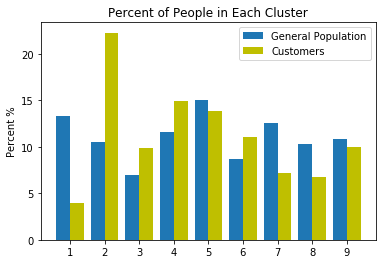

<Figure size 432x288 with 0 Axes>

(array([118911,  94169,  62354, 103807, 133713,  77453, 112357,  91996,
         96461], dtype=int64),
 array([ 7538, 42733, 18976, 28671, 26642, 21194, 13684, 13029, 19185],
       dtype=int64))

In [330]:
k = 9
plot_cluster_distribution_compare(k,azdias_pca,customers_pca)

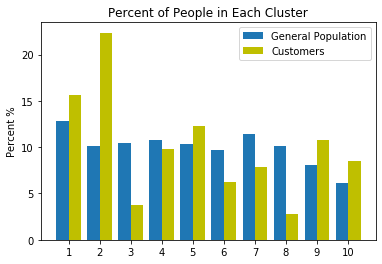

<Figure size 432x288 with 0 Axes>

(array([113960,  89940,  93454,  96176,  92430,  86297, 101739,  90333,
         72141,  54751], dtype=int64),
 array([29919, 42839,  7191, 18758, 23567, 12034, 15018,  5420, 20619,
        16287], dtype=int64))

In [331]:
k = 10
plot_cluster_distribution_compare(k,azdias_pca,customers_pca)

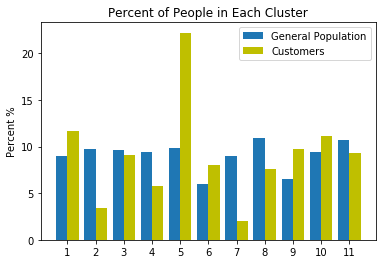

<Figure size 432x288 with 0 Axes>

(array([79831, 86293, 85584, 83960, 87687, 53234, 80172, 97148, 57925,
        83712, 95675], dtype=int64),
 array([22274,  6532, 17430, 11106, 42554, 15434,  3890, 14594, 18694,
        21239, 17905], dtype=int64))

In [332]:
k = 11
plot_cluster_distribution_compare(k,azdias_pca,customers_pca)

##### Finding for number of clusters:  
10 Clusters demonstrates significant difference from customer and general population   
Customer have higher possibility to be classified in cluster 2,9,10,1,5  
And very low possibility in cluster 8,3


In [400]:
# Return kmodel with number of clusters to be classified
kModel_10 = KMeans(n_clusters=10, random_state=26)
# Fit the model with data 
kModel_10.fit(azdias_pca)

# Predict the cluster of the data
azdias_labels = kModel_10.predict(azdias_pca)
customers_labels = kModel_10.predict(customers_pca)

# Return label of clusters and count of each cluster
labels, azdias_labels_counts = np.unique(azdias_labels, return_counts=True)
_, customers_labels_counts = np.unique(customers_labels, return_counts=True)

# Return percentage of people in each cluster
azdias_labels_pct = azdias_labels_counts * 100 / len(azdias_labels)
customers_labels_pct = customers_labels_counts * 100 / len(customers_labels)

In [401]:
label_customer = 2
label_general = 8
# Principle Component cluster center values for customer and general population
cluster_center_customers = kModel_10.cluster_centers_[label_customer]
cluster_center_general = kModel_10.cluster_centers_[label_general]

In [459]:
len(cluster_center_customers)

55

In [402]:
# Return original value for attributes of cluster center values for customer and general population
center_customers_inv = pca_55.inverse_transform(cluster_center_customers)
center_general_inv = pca_55.inverse_transform(cluster_center_general)

In [461]:
len(center_customers_inv)

128

In [403]:
feature_names = azdias_kmodel.columns

In [405]:
# Data frame to compare cluster center value of features for customer and general population,sorted by value of customoers
df_customer = pd.DataFrame({"Feature": feature_names, "Cluster_center_customers": center_customers_inv,"Cluster_center_general": center_general_inv}).sort_values(by="Cluster_center_customers",
                                                                                     ascending=False).reset_index(drop=True)
df_customer

,Feature,Cluster_center_customers,Cluster_center_general
0,LP_STATUS_FEIN_9.0,1.094303,-0.200029
1,WOHNLAGE,0.880333,-0.510695
2,MOBI_REGIO,0.834469,0.215515
3,KBA13_ANTG1,0.827690,-0.055433
4,PLZ8_ANTG1,0.813990,-0.020655
...,...,...,...
123,KBA13_ANTG4,-0.678348,0.142305
124,FINANZ_UNAUFFAELLIGER,-0.809149,0.048332
125,FINANZ_SPARER,-0.882805,-0.149527
126,KBA13_ANTG3,-0.986290,0.122928


Findings in cluster 2, customers are the major parts of this class:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; LP_STATUS_FEIN_9.0 - social status: customers are most possibly houseowners or top earners  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; WOHNLAGE - more customers living with rural neighbourhood or new building in rural neighbourhood  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; MOBI_REGIO - moving patterns: customers have low or no mobility  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; KBA13_ANTG1 - customers have higher share car owners between 1-2 within the PLZ8  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; PLZ8_ANTG1 - customers have higher share number of 1-2 family houses in the PLZ8

In [469]:
# Data frame to compare cluster center value of features for customer and general population,sorted by value gap between general population and customer
df_general = pd.DataFrame({"Feature" : feature_names, "Cluster_center_customers": center_customers_inv, "Cluster_center_population": center_general_inv,
             "Gap": abs(center_customers_inv-center_general_inv)}).sort_values(by="Gap", ascending=False).reset_index(drop=True)
df_general

,Feature,Cluster_center_customers,Cluster_center_population,Gap
0,KBA05_KW3,-0.127937,1.416220,1.544157
1,EWDICHTE,-1.105714,0.389988,1.495702
2,KBA13_HALTER_50,0.775263,-0.658407,1.433670
3,KBA13_ALTERHALTER_60,0.809394,-0.618799,1.428194
4,KBA13_ALTERHALTER_61,-0.493534,0.931931,1.425466
...,...,...,...,...
123,KBA13_TOYOTA,-0.161104,-0.120661,0.040443
124,FINANZ_ANLEGER,-0.443156,-0.476473,0.033318
125,KBA05_KW2,0.058975,0.040841,0.018134
126,KBA05_MOD8,0.304058,0.312767,0.008709


Findings in cluster 8, few customers in this cluster, major difference between customer and general population are:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; KBA05_KW3 - customers have much less share of cars with an engine power of more than 119 KW  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; EWDICHTE - customers living in lower density of inhabitants per square kilometer  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; KBA13_HALTER_50 - customers have higher share of car owners between 46 and 50 within the PLZ8  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; KBA13_ALTERHALTER_60 - customers have higher share of car owners between 46 and 60 within the PLZ8  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; KBA13_ALTERHALTER_61 - customers have much lower share of car owners elder than 61 within the PLZ8   


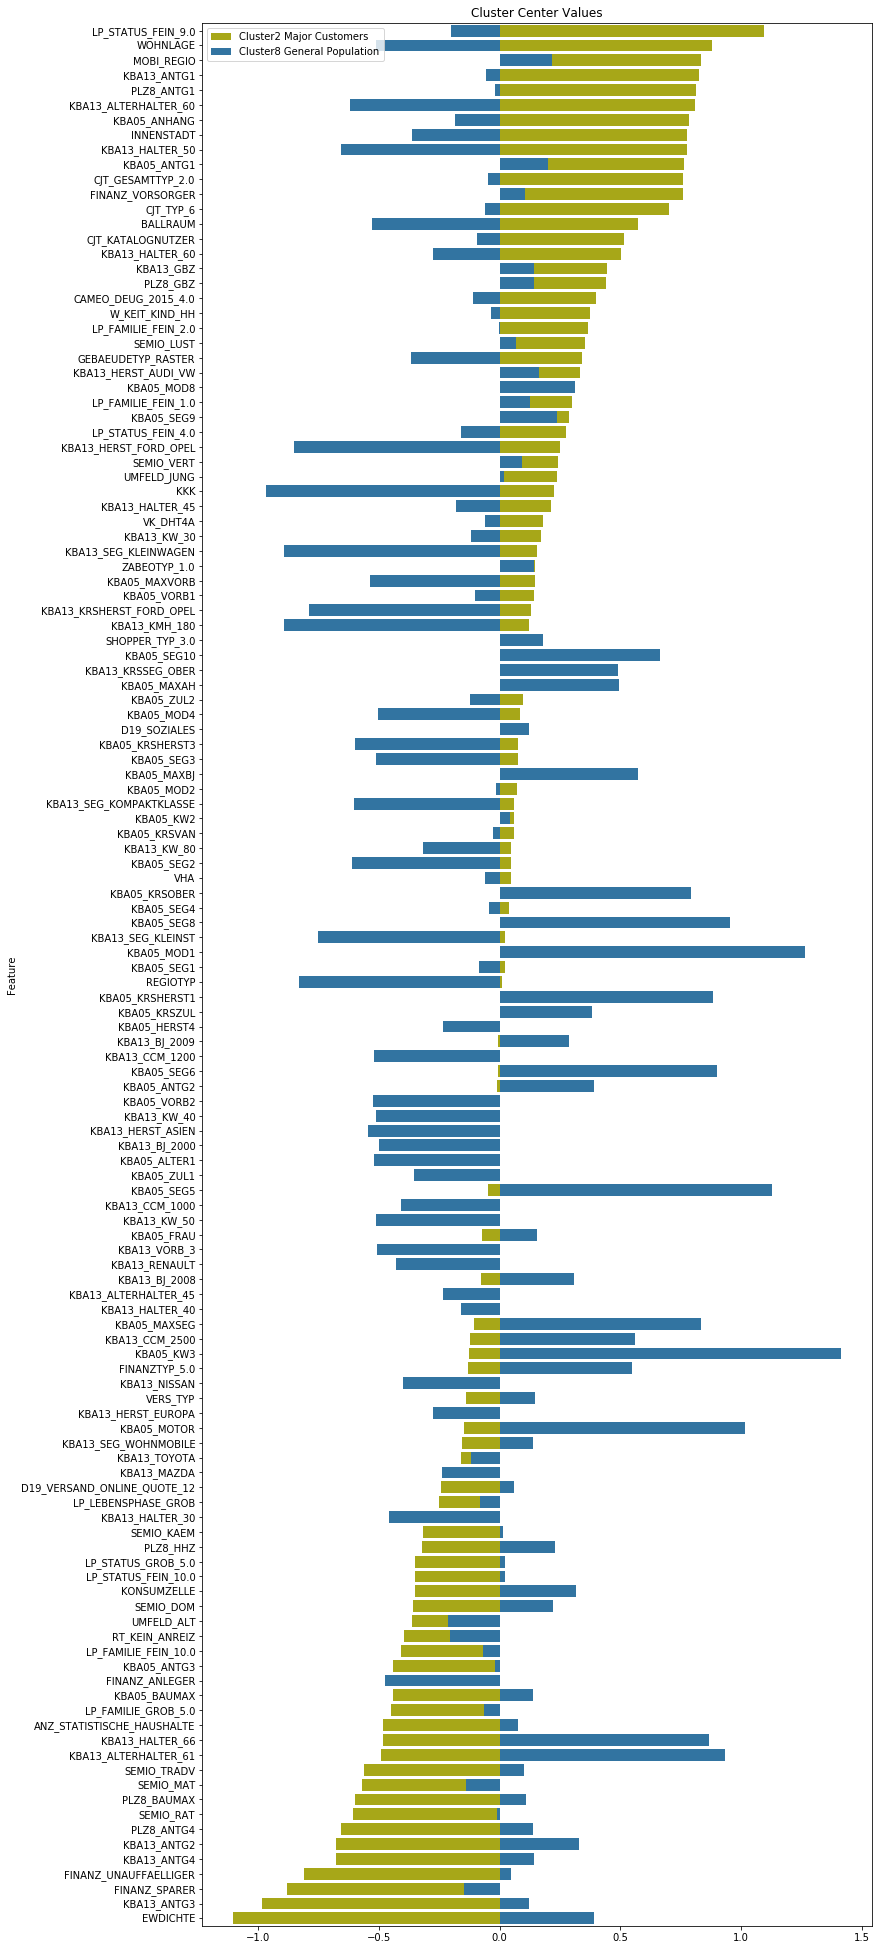

In [477]:
# Plot the features comparison between cluster 2 and cluster 8
plt.figure(figsize=(12,35))
sns.barplot(x=df_customer.Cluster_center_customers, y=df_customer.Feature, label="Cluster2 Major Customers",color='y')
sns.barplot(x=df_customer.Cluster_center_general, y=df_customer.Feature, label="Cluster8 General Population", color="#1f77b4")
plt.title('Cluster Center Values')
plt.xlabel('')
plt.legend(loc="upper left")

## Part 2: Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, we can verify the model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, we'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

##### As discussed in 1.3, I will employ the best model for mailout data set prediction

In [501]:
# Clean data for mailout train
mailout_train = df_load_mailout_train()
train_LNR = mailout_train['LNR']
y_train = mailout_train['RESPONSE']
mailout_train.drop(columns=['RESPONSE','LNR'],inplace=True)

C:\Users\wangx\.conda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [503]:
mailout_train_cleaned = df_clean(mailout_train)

C:\Users\wangx\.conda\envs\python36\lib\site-packages\sklearn\utils\extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\wangx\.conda\envs\python36\lib\site-packages\sklearn\utils\extmath.py:704: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)


In [504]:
# Clean data for mailout test
mailout_test = df_load_mailout_test()
test_LNR = mailout_test['LNR']
mailout_test.drop(columns=['LNR'],inplace=True)

C:\Users\wangx\.conda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [505]:
mailout_test_cleaned = df_clean(mailout_test)

In [506]:
mailout_test_cleaned.shape

(42833, 353)

In [507]:
X_train = mailout_train_cleaned.copy()

In [508]:
X_train.drop(columns=drop_list_less_important,inplace=True)

In [509]:
# Employ the 55 components PCA model
pca_55_train = PCA(n_components=55)
train_pca = pca_55_train.fit_transform(X_train)
train_pca.shape


(42962, 55)

In [510]:
# Return kmodel with number of clusters to be classified
kModel_kaggle = KMeans(n_clusters=10, random_state=26)

# Predict the cluster of the data
cluster_train = kModel_kaggle.fit_predict(X_train)

In [511]:
mailout_train_cleaned['cluster'] = pd.Series(cluster_train, index=X_train.index)

In [513]:
# Combine the one hot processed cluster value with cleaned data set
mailout_train_cleaned = pd.get_dummies(mailout_train_cleaned, columns = ["cluster"])

In [514]:
mailout_train_cleaned.shape

(42962, 363)

In [515]:
# Employ the model trained in previous part 1.3
model = xgb.XGBClassifier(booster='gbtree',
                          colsample_bylevel=1,
                          colsample_bynode=1,
                          colsample_bytree=0.7,
                          eval_metric='auc',
                          gamma=1.0,
                          gpu_id=-1,
                          importance_type='gain',
                          use_label_encoder=False,
                          max_delta_step=0,
                          missing=None,
                          n_jobs=-1,
                          nthread=None,
                          random_state=64,
                          reg_alpha=1e-09,
                          reg_lambda=1,
                          scale_pos_weight=1,
                          seed=None,
                          subsample=0.5,
                          max_depth=9,
                          min_child_weight=2,
                          n_estimators=200,
                          learning_rate=0.015,
                          )


In [516]:
model.fit(mailout_train_cleaned, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.015, max_delta_step=0,
              max_depth=9, min_child_weight=2, missing=None,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              nthread=24, num_parallel_tree=1, objective='binary:logistic',
              random_state=64, reg_alpha=1e-09, reg_lambda=1,
              scale_pos_weight=1, seed=64, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

## Part 3: Kaggle Competition

Now that we've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. Click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), will be taken to the competition page where

Entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [517]:
#Clean mailout test data set
X_test = mailout_test_cleaned.copy()
X_test.drop(columns=drop_list_less_important,inplace=True)
X_kaggle = mailout_test_cleaned

# Employ the 55 components PCA model
pca_55_test = PCA(n_components=55)
train_pca = pca_55_test.fit_transform(X_test)

# Employ the 10 cluster Kmeans model to predict the cluster of the data
cluster_test = kModel_kaggle.fit_predict(X_test)
X_kaggle['cluster'] = pd.Series(cluster_test, index=X_test.index)
X_kaggle = pd.get_dummies(X_kaggle, columns = ["cluster"])

predictions = model.predict_proba(X_kaggle)[:,1]

In [519]:
Kaggle = pd.DataFrame(predictions, test_LNR).reset_index()
Kaggle.columns = ["LNR", "RESPONSE"]


In [520]:
Kaggle.set_index('LNR', inplace = True)

In [289]:
Kaggle.to_csv('kaggle_submit_max.csv')